<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [24]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, CuDNNLSTM
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Preparation

In [0]:
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


## FOREX data

In [0]:
# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

# Normalise data
forex_mean = forexDataN.mean()
forex_std = forexDataN.std()
forexDataN = (forexDataN - forex_mean) / forex_std

dates = dataGbpEurRate.Date

forexData = {'Date':dataGbpEurRate.Date,'Value':forexDataN}

mainDf = pd.DataFrame(forexData)

### FOREX feature engineering

In [0]:
ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

fiveDayMovingAverages = getMovingAverages(forexDataN, 5)
tenDayMovingAverages = getMovingAverages(forexDataN, 30)

fiveDayDict = {ukFOREXdates[i]: fiveDayMovingAverages[i] for i in range(len(fiveDayMovingAverages))}
tenDayDict = {ukFOREXdates[i]: tenDayMovingAverages[i] for i in range(len(tenDayMovingAverages))}

## Interest Rate Data (INT)


### INT data retreival

In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
def cleanDataSets(dataset):

    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    for index, row in mainDf.iterrows():
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        if(value==1000000):
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR1mC = cleanDataSets(GBR1mJson)
EUR1mC = cleanDataSets(EUR1mJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

In [0]:
def getDifferenceFeatures(xDict, yDict):
    dates = []
    valuesX = []
    valuesY = []
    ratioValues = []                      

    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    diffValues = datasetXarr - datasetYarr

    data_mean = diffValues.mean()
    data_std = diffValues.std()
    dataNormalised = (diffValues - data_mean) - data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

GBPEURovrRatio = getDifferenceFeatures(GBRovrC,EURovrC)
GBPEUR1mRatio = getDifferenceFeatures(GBR1mC,EUR1mC)
GBPEUR3mRatio = getDifferenceFeatures(GBR3mC,EUR3mC)
GBPEUR6mRatio = getDifferenceFeatures(GBR6mC,EUR6mC)
GBPEUR12mRatio = getDifferenceFeatures(GBR12mC,EUR12mC)

## Inflation data (CPI)

### CPI data retreival

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [32]:
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        roundD = row['Date'].replace(day=1)

        value= dataset.get(pd.Timestamp(roundD),1000000)

        if(value==1000000):
            clean = False
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    if(clean==True):
        print("Data is clean")

    return cleanedDataDict


ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [0]:
dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)

    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()

ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## International Reserves data (IR)

### IR data retreival

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [35]:
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

In [0]:
IRdates = []
ukIRarr = []
euIRarr = []

for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)


ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)

ukEuIRRatio = ukIRarr / euIRarr

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [38]:
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        if(value==1000000):
            mainDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict


ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [0]:
BOPdates = []
ukBOParr = []
euBOParr = []

for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)

ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

## Creating full data matrix

In [40]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

completeDf = pd.DataFrame(columns=['Date','ForexRate','5dayMovingAvg','20dayMovingAvg','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0
 
for index, row in mainDf.iterrows():

    date = row['Date']
    forex = row['Value']
    movingAvg5Day = fiveDayDict.get(date, 0)
    movingAvg10Day = tenDayDict.get(date, 0)
    
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)

    ovrI = GBPEURovrRatio.get(date, 0)
    i1month = GBPEUR1mRatio.get(date, 0)
    i3month = GBPEUR3mRatio.get(date, 0)
    i6month = GBPEUR6mRatio.get(date, 0)
    i12month = GBPEUR12mRatio.get(date, 0)

    completeDf = completeDf.append({'Date':date,
                            'ForexRate':forex,
                            '5dayMovingAvg':movingAvg5Day,
                            '20dayMovingAvg':movingAvg10Day,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '1mLIBOR': i1month,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)

print(completeDf)

           Date  ForexRate  5dayMovingAvg  20dayMovingAvg  CPIRatio   IRRatio  \
0    2001-01-02  1.638603   1.638603       1.638603       -1.445720  4.969333   
1    2001-01-03  1.714443   1.676523       1.676523       -1.445720  4.969333   
2    2001-01-04  1.650130   1.667726       1.667726       -1.445720  4.969333   
3    2001-01-05  1.591885   1.648765       1.648765       -1.445720  4.969333   
4    2001-01-08  1.632535   1.645519       1.645519       -1.445720  4.969333   
...         ...       ...        ...            ...             ...       ...   
4734 2019-09-24 -1.055864  -1.073823      -1.203076        0.563933  0.376361   
4735 2019-09-25 -1.087414  -1.072974      -1.192822        0.563933  0.376361   
4736 2019-09-26 -1.100155  -1.075522      -1.183742        0.563933  0.376361   
4737 2019-09-27 -1.118357  -1.088627      -1.176886        0.563933  0.376361   
4738 2019-09-30 -1.083167  -1.088992      -1.169484        0.563933  0.376361   

      BOPRatio  OvrLIBOR   

# Variable Correlation

In [0]:
variables = ['CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

forex = completeDf['ForexRate'].tolist()
correlations = []

for x in range(len(columns)):
    
    column = completeDf[columns[x]].tolist()

    r = np.corrcoef(forex, column)

    correlations.append(r[0,1])

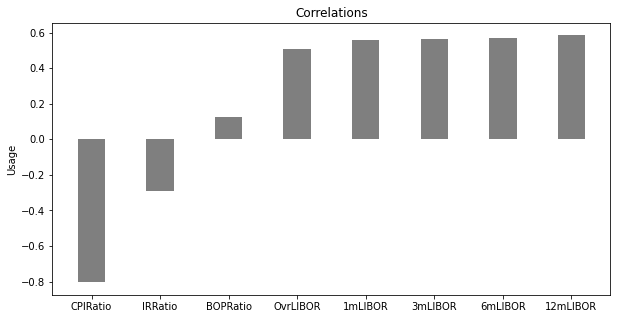

In [99]:
y_pos = np.arange(0,16,2)
plt.figure(figsize=(10,5))
plt.bar(y_pos, correlations, align='center', alpha=0.5, color=(0.0, 0.0, 0.0, 1))
plt.xticks(y_pos, variables)
plt.ylabel('Usage')
plt.title('Correlations')

plt.show()

# Neural Networks

## Data setup

In [0]:
import math

EPOCHS = 10
EVALUATION_INTERVAL = 100
VALIDATION_STEPS = 50
TIME_LAGS = 600
PREDICTION_HORIZON = 180
STEP = 30
BATCH_SIZE = 30
FOLDS = 4
FUTURE_STEP = 30

features = ['20dayMovingAvg']

dataSet = completeDf[features]
dataSet.index = mainDf['Date']
dataSet = dataSet.values

VAL = int(len(dataSet) * 0.6)
TEST = int(len(dataSet) * 0.8)

fold_steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

for x in range(0,len(dataSet), fold_steps):
    fold_locations.append(x)

## Single-step LSTM

### Building network

In [0]:
inputShape = int(TIME_LAGS/STEP)

def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(inputShape, len(features))),
        layers.Dense(1)
    ])

    singleStepLSTMModel.compile(optimizer='adam', loss='mse')
    return singleStepLSTMModel

### Cross validation

In [43]:
def singleStepDataSplit(dataset, target, startIndex, endIndex, timeLags,
                target_size, step):  
    data = []
    labels = []

    startIndex = startIndex + timeLags

    if endIndex is None:
        endIndex = len(dataset) - target_size

    for i in range(startIndex, endIndex):
        dataIndices = range(i-timeLags, i, step)
        data.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

models = []
results = []

for x in range(1, FOLDS):

    model = singleStepLSTM()

    valIndex = fold_locations[x]
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    xTrain, yTrain = singleStepDataSplit(dataSet, dataSet[:, 0], 0, valIndex, TIME_LAGS, PREDICTION_HORIZON, STEP)
    xVal, yVal = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, TIME_LAGS, PREDICTION_HORIZON, STEP)

    dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
    dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()

    dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
    dataVal = dataVal.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=dataVal, validation_steps=50)
    
    models.append(model)
    results.append(result)
    
print(result.history['val_loss'])

--------------------- Model 1/3 --------------------------
Epoch 1/10
100/100 [==============================] - 1s 12ms/step - loss: 0.0584 - val_loss: 1.8694
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 1.8971
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 1.9268
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0122 - val_loss: 1.9507
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0117 - val_loss: 1.9749
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0113 - val_loss: 2.0024
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0109 - val_loss: 2.0328
Epoch 8/10
100/100 [==============================] - 1s 9ms/step - loss: 0.0106 - val_loss: 2.0630
Epoch 9/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0103 - val_loss: 2.0890
Epoch 10/10
100/100 [=============

### Prediction visualisation

[-0.63212717]


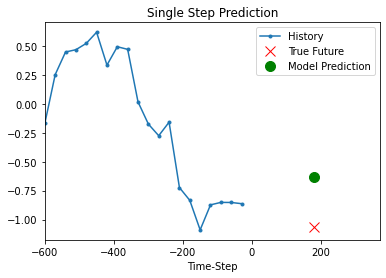

[-0.6206217]


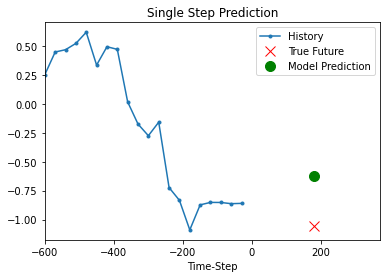

[-0.6659673]


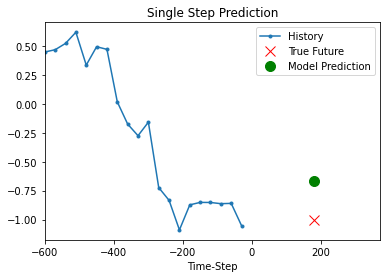

[-0.74873793]


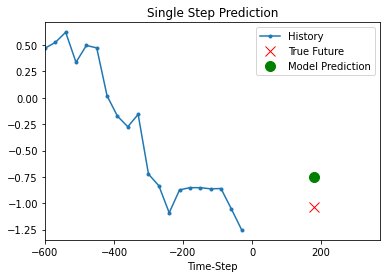

[-0.7707255]


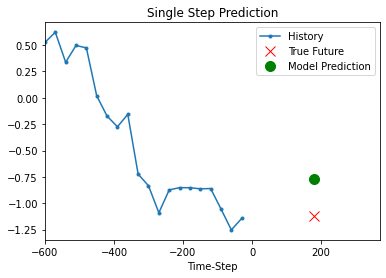

[-0.77182454]


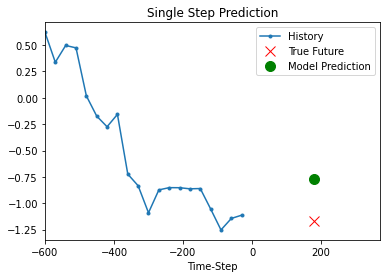

[-0.75966865]


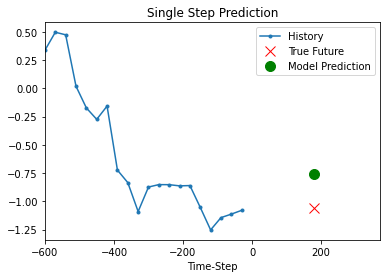

[-0.7460495]


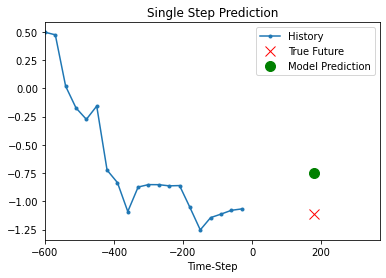

[-0.7335334]


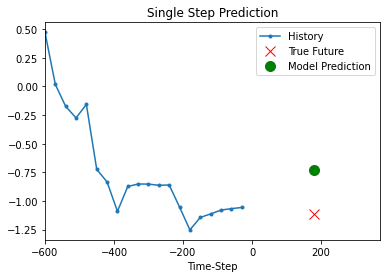

[-0.7102673]


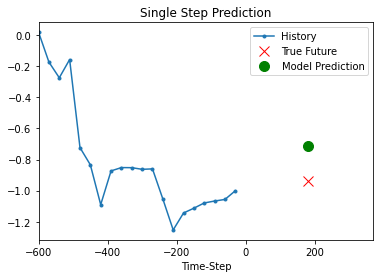

[-0.70457345]


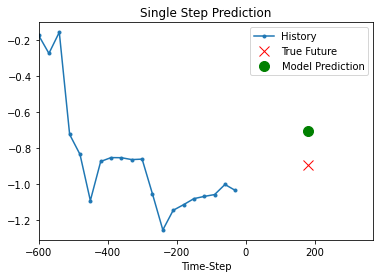

[-0.72570413]


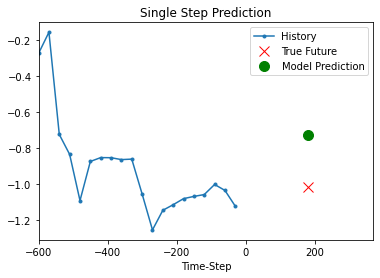

[-0.75201255]


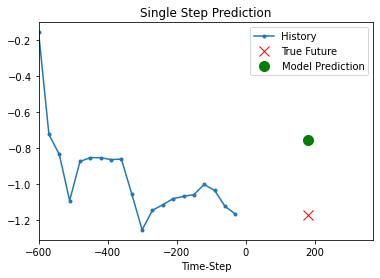

[-0.74101746]


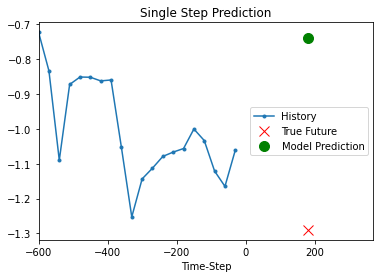

[-0.63212717]


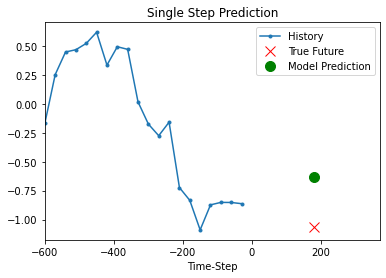

[-0.6206217]


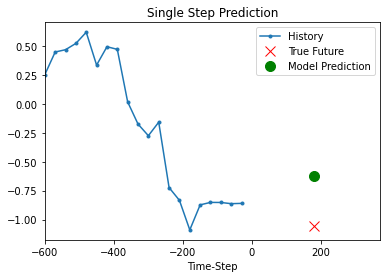

[-0.6659673]


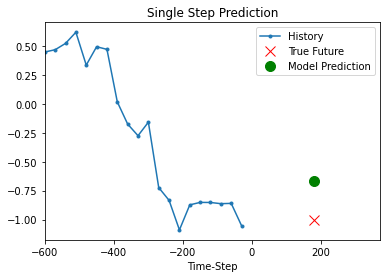

[-0.74873793]


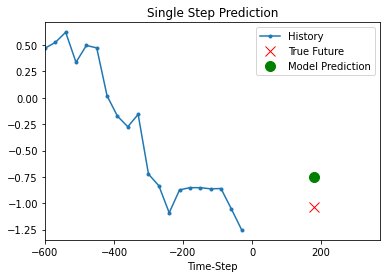

[-0.7707255]


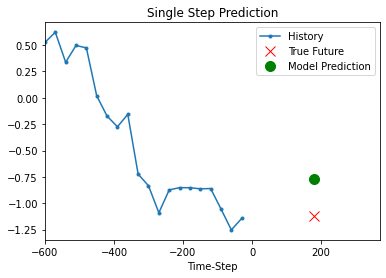

[-0.77182454]


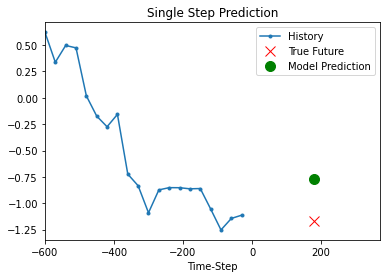

[-0.75966865]


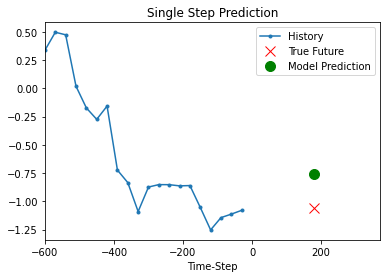

[-0.7460495]


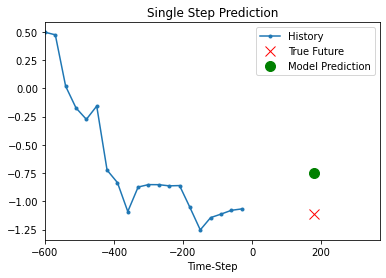

[-0.7335334]


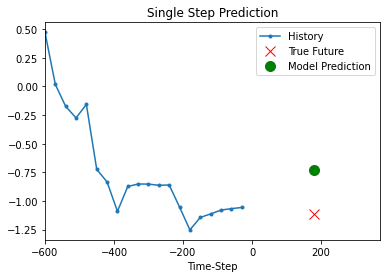

[-0.7102673]


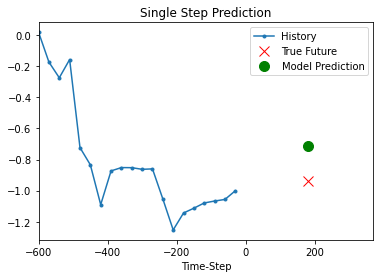

[-0.70457345]


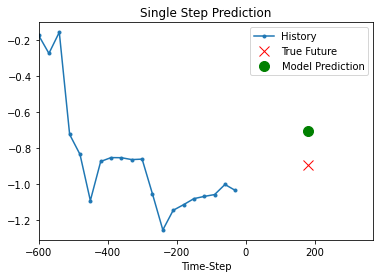

[-0.72570413]


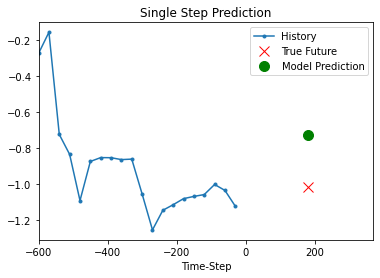

[-0.75201255]


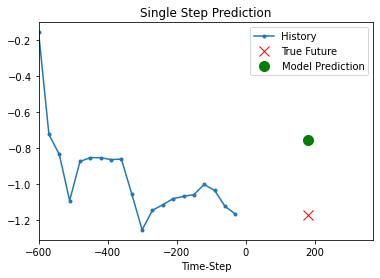

[-0.74101746]


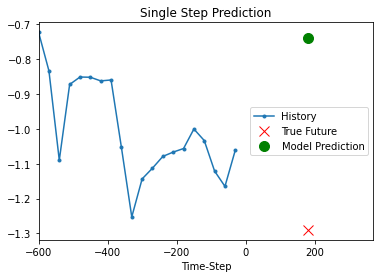

[-0.63212717]


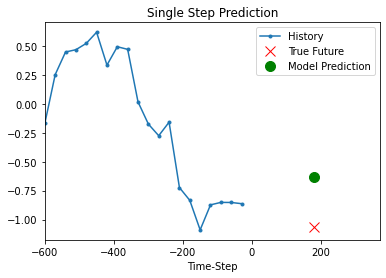

[-0.6206217]


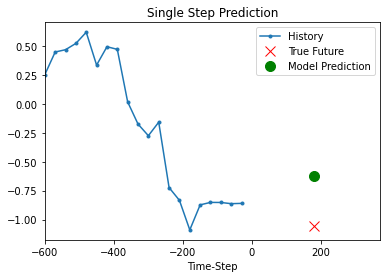

[-0.6659673]


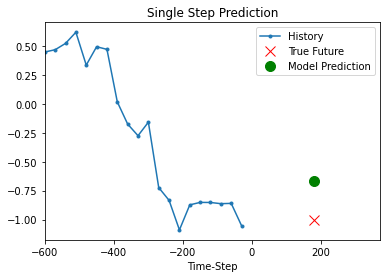

[-0.74873793]


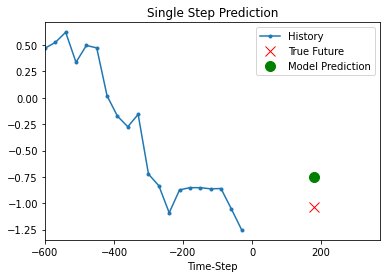

[-0.7707255]


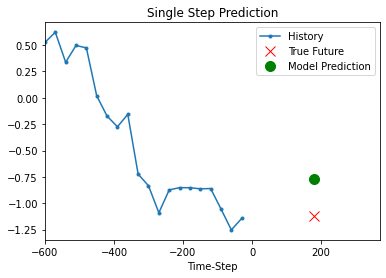

[-0.77182454]


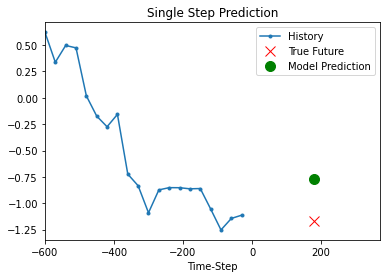

[-0.75966865]


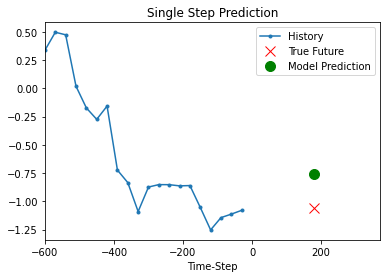

[-0.7460495]


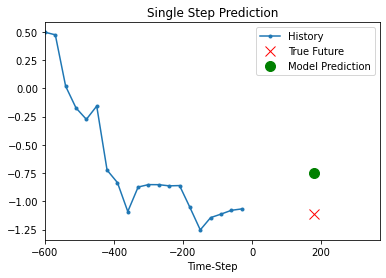

[-0.7335334]


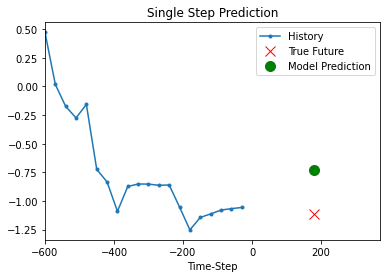

[-0.7102673]


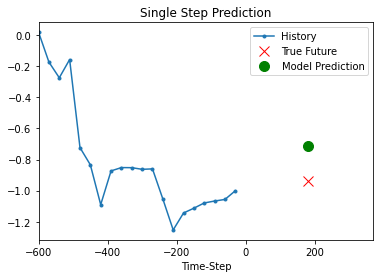

[-0.70457345]


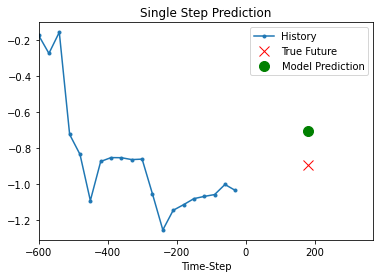

[-0.72570413]


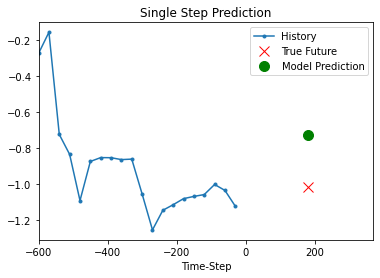

[-0.75201255]


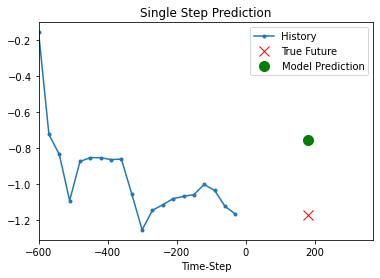

[-0.74101746]


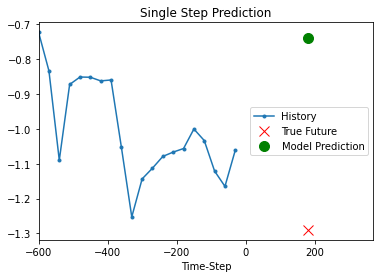

[-0.63212717]


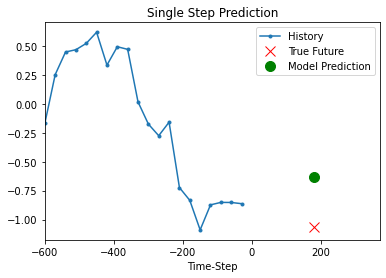

[-0.6206217]


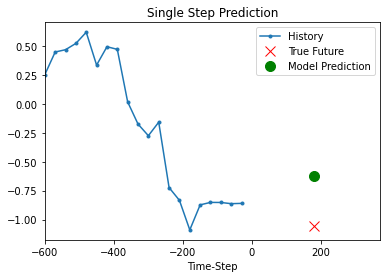

[-0.6659673]


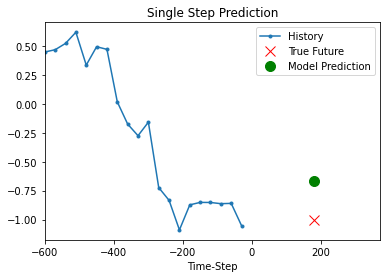

[-0.74873793]


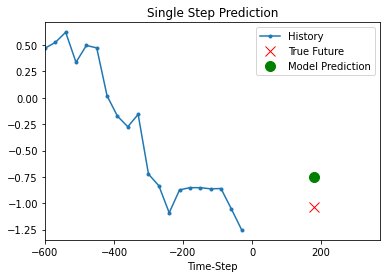

[-0.7707255]


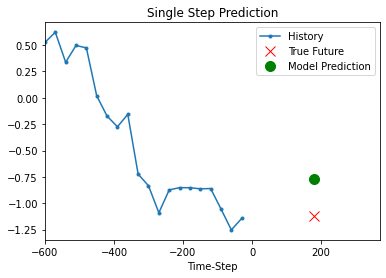

[-0.77182454]


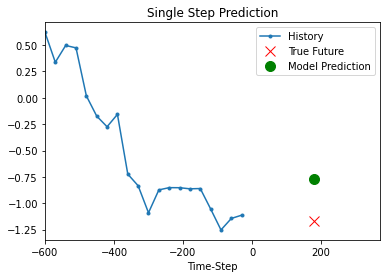

[-0.75966865]


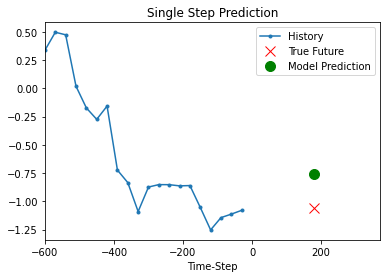

[-0.7460495]


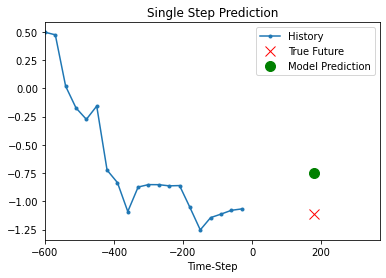

[-0.7335334]


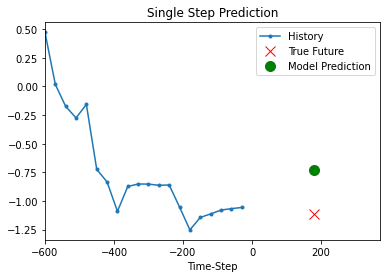

[-0.7102673]


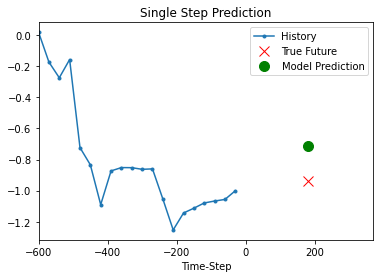

[-0.70457345]


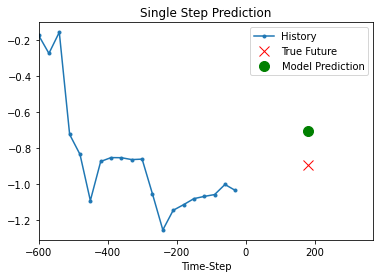

[-0.72570413]


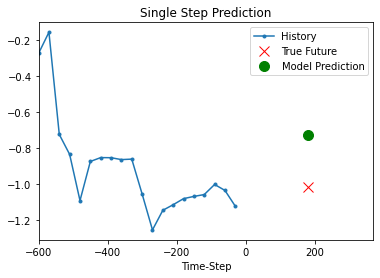

[-0.75201255]


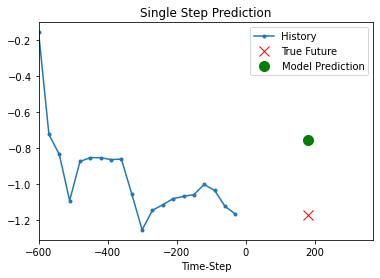

[-0.74101746]


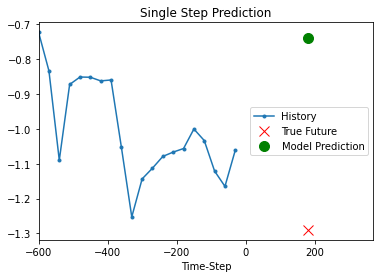

[-0.63212717]


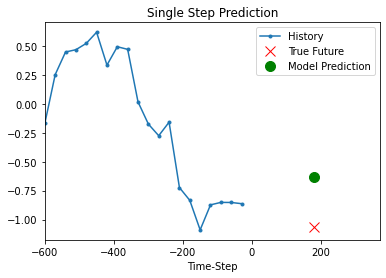

[-0.6206217]


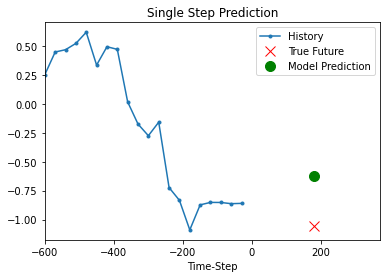

[-0.6659673]


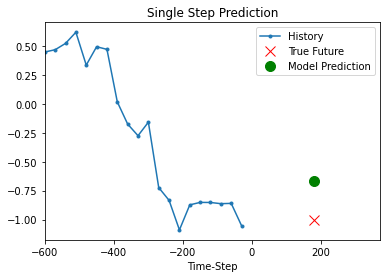

[-0.74873793]


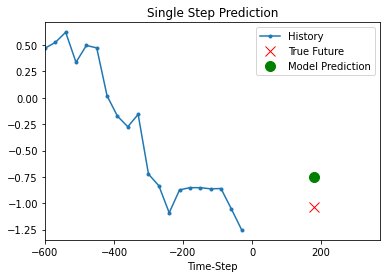

[-0.7707255]


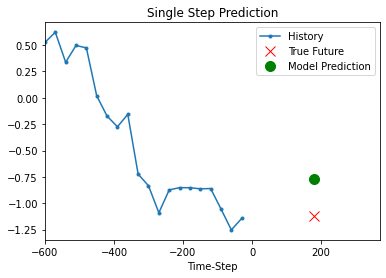

[-0.77182454]


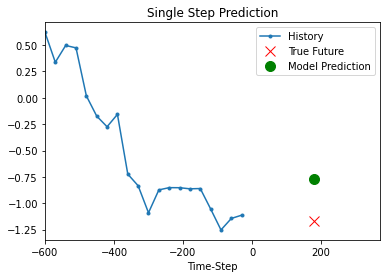

[-0.75966865]


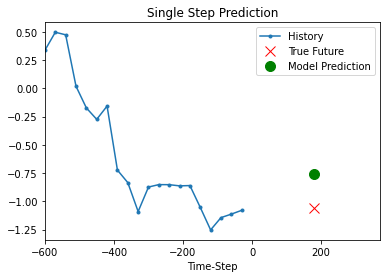

[-0.7460495]


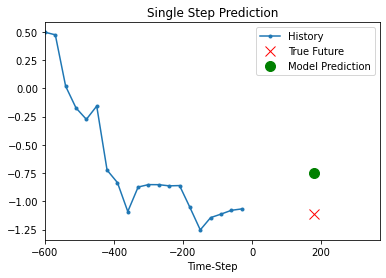

[-0.7335334]


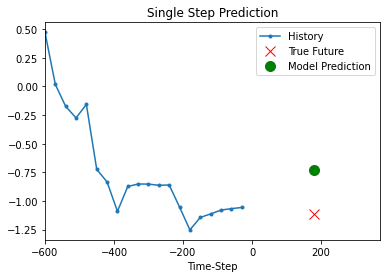

[-0.7102673]


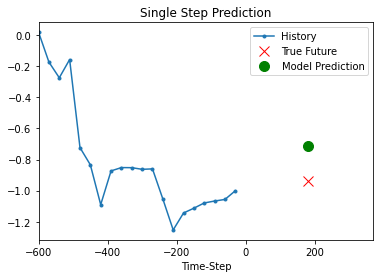

[-0.70457345]


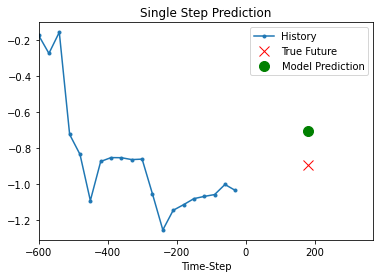

[-0.72570413]


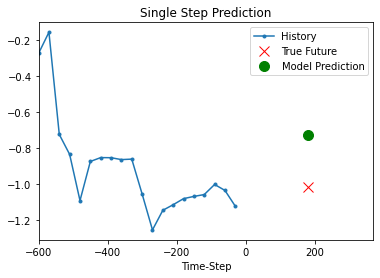

[-0.75201255]


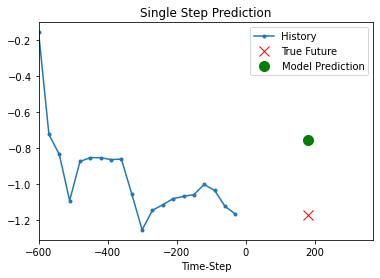

[-0.74101746]


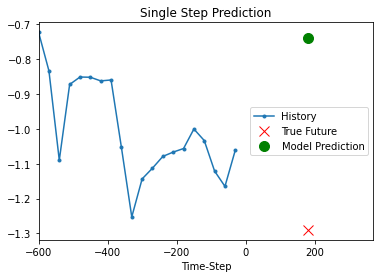

[-0.63212717]


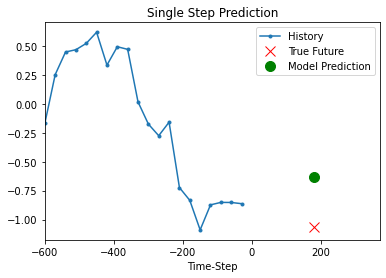

[-0.6206217]


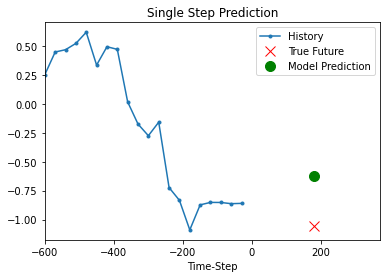

[-0.6659673]


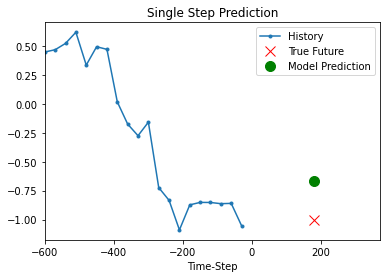

[-0.74873793]


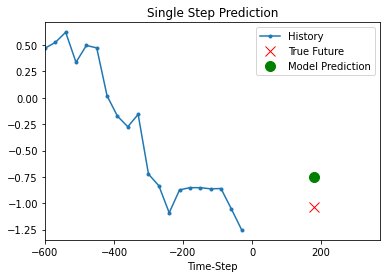

[-0.7707255]


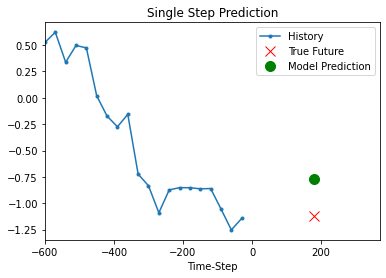

[-0.77182454]


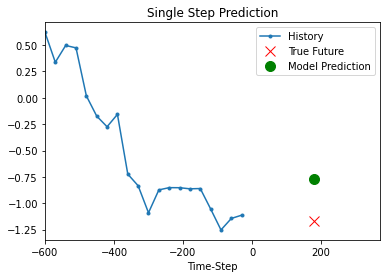

[-0.75966865]


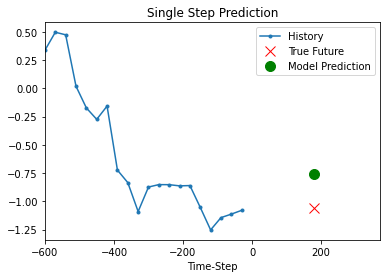

[-0.7460495]


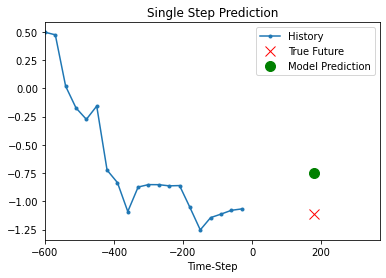

[-0.7335334]


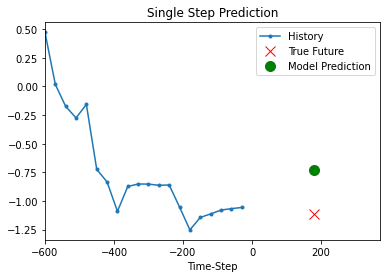

[-0.7102673]


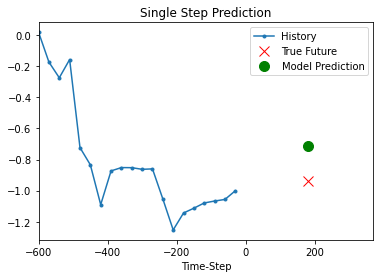

[-0.70457345]


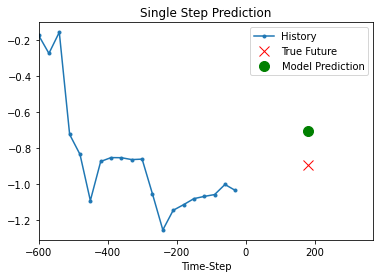

[-0.72570413]


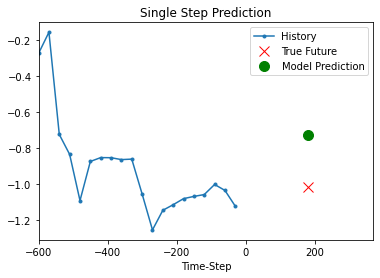

[-0.75201255]


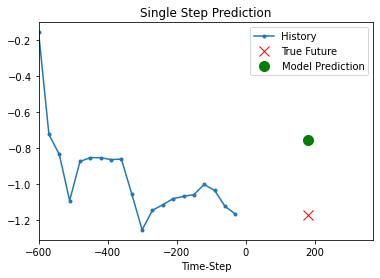

[-0.74101746]


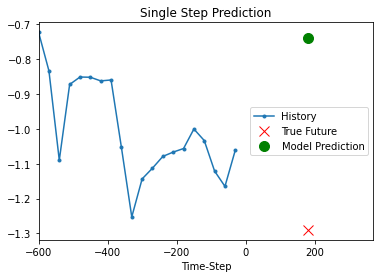

[-0.63212717]


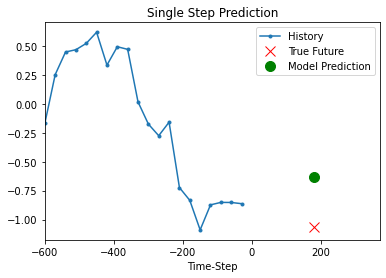

[-0.6206217]


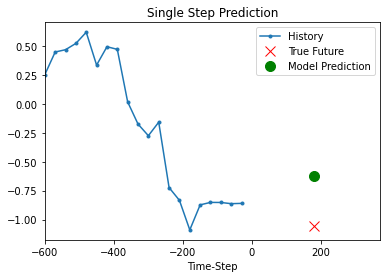

[-0.6659673]


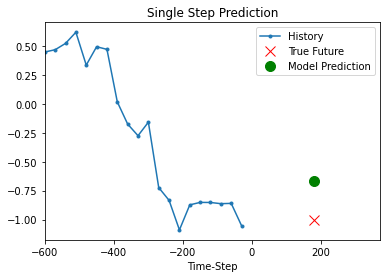

[-0.74873793]


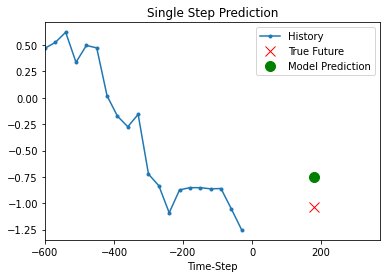

[-0.7707255]


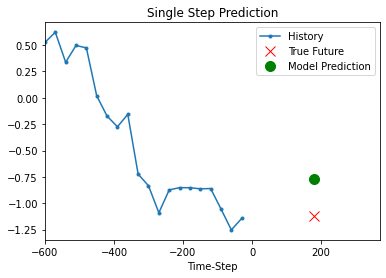

[-0.77182454]


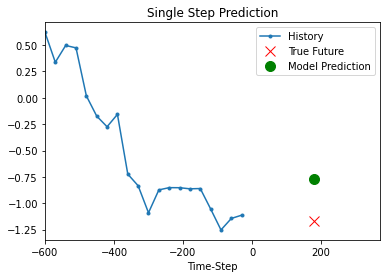

[-0.75966865]


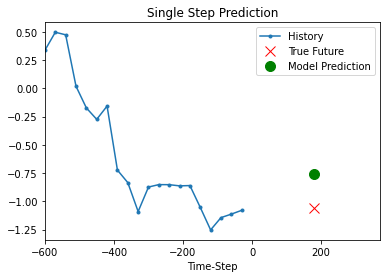

[-0.7460495]


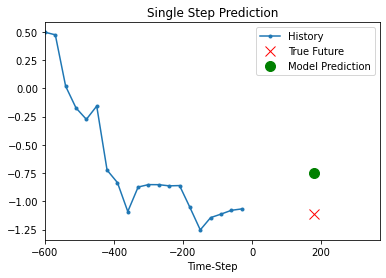

[-0.7335334]


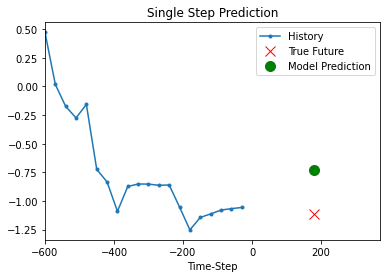

[-0.7102673]


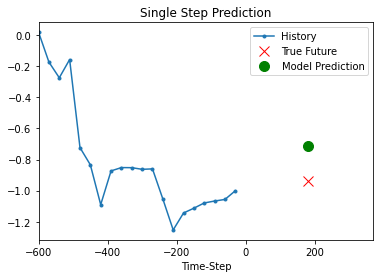

[-0.70457345]


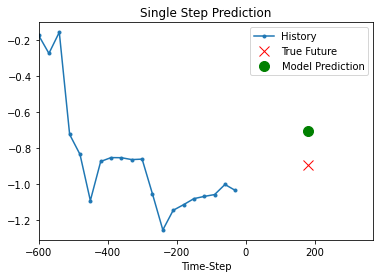

[-0.72570413]


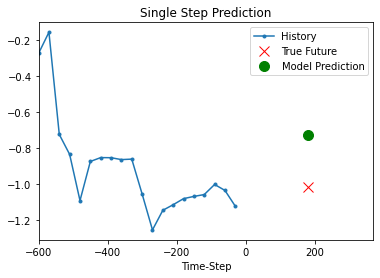

[-0.75201255]


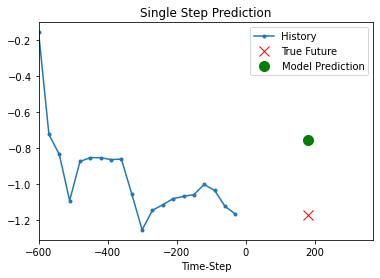

[-0.74101746]


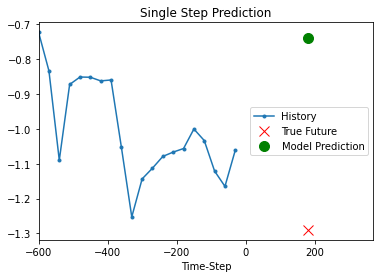

[-0.63212717]


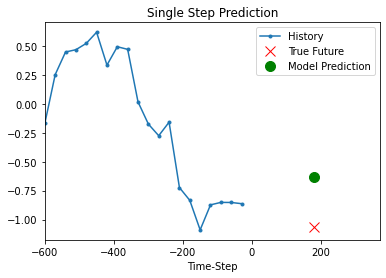

[-0.6206217]


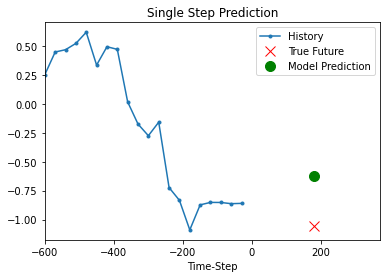

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(TIME_LAGS,STEP)

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


for x, y in dataVal.take(100):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                        model.predict(x)[0]], PREDICTION_HORIZON,
                    'Single Step Prediction')
    print(model.predict(x)[0])
    plot.show()

### Single-step tests

In [45]:
def singleStepModelTests(model, xTest, yTest):

    correctDirection = 0

    noDatapoints = len(xTest)
    noPredictions = 6

    mse = model.evaluate(xTest,yTest)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        prediction = model.predict(past)[0]
        future = yTest[x]

        if((current > prediction) == (current > future)):
                correctDirection = correctDirection + 1

    print("----------")
    print("MSE: " + str(round(mse,3)))
    
    print("--------------")
    directionClass = correctDirection / noDatapoints
    print("Direction classification: " + str(round(directionClass,3)))

singleStepModelTests(model, xTest, yTest)

NameError: ignored

## Multi-step LSTM

### Building network

In [0]:
inputShape = int(TIME_LAGS / STEP)

def multiStepLSTM():
    multiStepLSTMModel = keras.Sequential([
        layers.LSTM(units=32, return_sequences=True, input_shape = (inputShape, len(features))),
        layers.LSTM(16, activation='relu'),
        layers.Dense(PREDICTION_HORIZON/FUTURE_STEP)
    ])

    multiStepLSTMModel.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return multiStepLSTMModel

multiStepModel = multiStepLSTM()

### Cross validation

In [0]:
def splitData(dataset, target, start_index, end_index, history_size,
                      target_size, step, future_step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        indiciesL = range(i, i+target_size, future_step)
        labels.append(target[indiciesL])


    return np.array(data), np.array(labels)

models = []
results = []

for x in range(1, FOLDS):

    valIndex = fold_locations[x]

    multiStepModel = multiStepLSTM()
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    xTrainMulti, yTrainMulti = splitData(dataSet, dataSet[:, 0], 0, valIndex, TIME_LAGS, PREDICTION_HORIZON, STEP, FUTURE_STEP)
    xValMulti, yValMulti = splitData(dataSet, dataSet[:, 0], valIndex, None, TIME_LAGS, PREDICTION_HORIZON, STEP, FUTURE_STEP)

    dataTrainMulti = tf.data.Dataset.from_tensor_slices((xTrainMulti, yTrainMulti))
    dataTrainMulti = dataTrainMulti.cache().batch(BATCH_SIZE).repeat()

    dataValMulti = tf.data.Dataset.from_tensor_slices((xValMulti, yValMulti))
    dataValMulti = dataValMulti.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    result = multiStepModel.fit(dataTrainMulti, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=dataValMulti, validation_steps=50)
    
    models.append(multiStepModel)
    results.append(result)

### Prediction visualisation

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(TIME_LAGS,STEP)
  num_out = len(true_future) * FUTURE_STEP

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=FUTURE_STEP), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=FUTURE_STEP), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

model = models[-1]

for x, y in dataTrainMulti.take(200):

    #print((multiStepModel.predict(x)[0]).index(max(multiStepModel.predict(x)[0])))
    print(model.predict(x)[0])
    multi_step_plot(x[0], y[0], model.predict(x)[0])


### Multi-step tests

In [0]:
# MSE Metric
mseResult = multiStepModel.evaluate(xValMulti,yValMulti)
print("Model MSE: ", mseResult)

def multiStepModelTests(model, xTest, yTest):

    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    noDatapoints = len(xTest)
    noPredictions = len(totalSquaredError)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        predictions = model.predict(past)[0]
        future = yTest[x]

        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        futureRemovingMax = np.delete(future, actualMax)
        actual2ndMax = np.argmax(futureRemovingMax)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

        for y in range(noPredictions):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1

    print("---------------")
    for x in range(noPredictions):
        mse = totalSquaredError[x] / noDatapoints
        print("MSE (Month " + str(x+1) + "): " + str(round(mse,3)))

    averageMSE = (sum(totalSquaredError) / noDatapoints) / noPredictions
    print("Average MSE: " + str(round(averageMSE,3)))


    print("---------------")
    for x in range(noPredictions):
        percentInterval = correctDirection[x] / noDatapoints
        print("Direction (Month " + str(x+1) + "): " + str(round(percentInterval,3)))

    directionClass = (sum(correctDirection) / noDatapoints) / noPredictions
    print("Average classification: " + str(round(directionClass,3)))

    print("---------------")
    bestMonthClass = correctMax / noDatapoints
    bestMonthRelaxedClass = correctMaxRelaxed / noDatapoints

    print("Correct best month: " + str(round(bestMonthClass,3)))
    print("Correct top 2 best month: " + str(round(bestMonthRelaxedClass,3)))

multiStepModelTests(multiStepModel, xValMulti, yValMulti)